## Incident Management - Priority prediction, Volume Forecasting & Predicting RFC

### Importing the necessary libraires

In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
import statsmodels.api as sm
import sklearn.externals
import joblib

### Importing warnings to ignore the warning

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Data

### Importing Raw Data

In [4]:
# Importing the csv file
data = pd.read_csv('D:/Codebase/Incident_Analysis/ITSM-Incident-Management/datasets/incident_data.csv')

## Source Code

### Exploratory Data Analysis

In [5]:
data.shape

(141712, 36)

In [6]:
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [7]:
data.head(3)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00


In [9]:
# Looking for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

## 1. Predicting Priorities

### Feature Selection

Only the features which are available when the tickets arrives can be used to predict priority. Therefore, we have used only 10 predictors.
The features are - 
1. caller_id: identifier of the user affected;
2. opened_by: identifier of the user who reported the incident;
3. sys_created_by: identifier of the user who registered the incident;
4. contact_type: categorical attribute that shows by what means the incident was reported;
5. location: identifier of the location of the place affected;
6. category: first-level description of the affected service;
7. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
8. impact: description of the impact caused by the incident (values: High, Medium, Low);
9. urgency: description of the urgency informed by the user for the incident resolution (values: High, Medium, Low);
10. notify: categorical attribute that shows whether notifications were generated for the incident;

### Data Processing / Data Munging

Most of the columns have (?) in place of unknown values. Replacing them by Unknown

In [10]:
data.replace(['?'],'Unknown',inplace=True)

### Selecting the feature for X and Y

In [12]:
X = data.loc[:,['caller_id','opened_by','sys_created_by','contact_type','location','category','subcategory','impact','urgency','notify']]
Y = data.priority

### Data surity - The checking of the head or info and any other information can be done here

In [13]:
X.head(2)

,caller_id,opened_by,sys_created_by,contact_type,location,category,subcategory,impact,urgency,notify
0,Caller 2403,Opened by 8,Created by 6,Phone,Location 143,Category 55,Subcategory 170,2 - Medium,2 - Medium,Do Not Notify
1,Caller 2403,Opened by 8,Created by 6,Phone,Location 143,Category 55,Subcategory 170,2 - Medium,2 - Medium,Do Not Notify


In [14]:
# Label Encoding
enc= LabelEncoder()
for i in (0,1,2,3,4,5,6,7,8,9):
    X.iloc[:,i] = enc.fit_transform(X.iloc[:,i])

In [15]:
# Splitting the data into test and train for calculating accuracy
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

In [16]:
# Standardization technique
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
X_train.shape

(99198, 10)

In [18]:
X_test.shape

(42514, 10)

## Models

### 1. Support Vector Machine

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [19]:
# Training the model
from sklearn.svm import SVC
rbf_svc = SVC(kernel='rbf',C=10,gamma=0.1).fit(X_train,Y_train)

In [20]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [21]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_test,y_predict_svm))
print(classification_report(Y_test,y_predict_svm))

0.9847814837465305
              precision    recall  f1-score   support

1 - Critical       0.98      1.00      0.99       657
    2 - High       0.99      1.00      0.99       873
3 - Moderate       0.98      1.00      0.99     38825
     4 - Low       0.99      1.00      0.99      1179
     Unknown       0.98      0.35      0.51       980

    accuracy                           0.98     42514
   macro avg       0.98      0.87      0.90     42514
weighted avg       0.98      0.98      0.98     42514



In [22]:
c_matrix = confusion_matrix(Y_test,y_predict_svm)

print(c_matrix)

[[  657     0     0     0     0]
 [    0   872     0     0     1]
 [    0     0 38821     0     4]
 [    0     0     0  1178     1]
 [   16    11   597    17   339]]


## Creating the graph of TP and FP

### TP - True Positive & FP - False Positive
From the confusion matrix, we can create a Grouped-Bar Chart containing TP and FP based on each type -
1. 1-Critical
2. 2-High
3. 3-Medium
4. 4-Low
5. Unknown

In [42]:
import plotly.graph_objs as px

xaxis = ['1-Critical','2-High', '3-Medium', '4-Low']
trace_data = []
tp = []
fp = []
cr_arr = []
hi_arr = []
md_arr = []
lw_arr = []

# Creating the array to compare between algorithms group by priority (Accuary Percentage)
cr_arr.append((c_matrix[0][0]*100)/(c_matrix[0][0]+c_matrix[0][4]))
hi_arr.append((c_matrix[1][1]*100)/(c_matrix[1][1]+c_matrix[1][4]))
md_arr.append((c_matrix[2][2]*100)/(c_matrix[2][2]+c_matrix[2][4]))
lw_arr.append((c_matrix[3][3]*100)/(c_matrix[3][3]+c_matrix[3][4]))


for i in range (0,len(c_matrix)-1):    
    tp.append(c_matrix[i][i])
    fp.append(c_matrix[i][len(c_matrix[i]) - 1])
    
trace1 = px.Bar(x=xaxis, y= tp, name='True Positive')
trace2 = px.Bar(x=xaxis, y= fp, name='False Positive')
trace_data.append(trace1)
trace_data.append(trace2)
    
layout = px.Layout(barmode = 'group')
fig = px.Figure(data = trace_data, layout = layout)
fig.update_yaxes(type="log", range=[0,5]) # log range: 10^0=1, 10^5=100000
fig.show()
        

### 2. Decision Tree

Decision Tree consists of :
1. Nodes : Test for the value of a certain attribute.
2. Edges/ Branch : Correspond to the outcome of a test and connect to the next node or leaf.
3. Leaf nodes : Terminal nodes that predict the outcome (represent class labels or class distribution).


In [25]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model_dtree=DecisionTreeClassifier()
model_dtree.fit(X_train,Y_train)

DecisionTreeClassifier()

In [26]:
# Predicting the model
y_predict_dtree = model_dtree.predict(X_test)

In [27]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_test,y_predict_dtree))
print(classification_report(Y_test,y_predict_dtree))

0.9972479653761114
              precision    recall  f1-score   support

1 - Critical       1.00      1.00      1.00       657
    2 - High       0.99      1.00      0.99       873
3 - Moderate       1.00      1.00      1.00     38825
     4 - Low       0.99      1.00      0.99      1179
     Unknown       0.96      0.91      0.94       980

    accuracy                           1.00     42514
   macro avg       0.99      0.98      0.99     42514
weighted avg       1.00      1.00      1.00     42514



In [28]:
c_dtree_matrix = confusion_matrix(Y_test,y_predict_dtree)

print(c_dtree_matrix)

[[  657     0     0     0     0]
 [    0   870     0     0     3]
 [    0     0 38796     0    29]
 [    0     0     0  1178     1]
 [    1     6    66    11   896]]


## Creating the graph of TP and FP

### TP - True Positive & FP - False Positive
From the confusion matrix, we can create a Grouped-Bar Chart containing TP and FP based on each type -
1. 1-Critical
2. 2-High
3. 3-Medium
4. 4-Low
5. Unknown

In [43]:
import plotly.graph_objs as px

xaxis = ['1-Critical','2-High', '3-Medium', '4-Low']
trace_data = []
tp = []
fp = []

# Creating the array to compare between algorithms group by priority (Accuary Percentage)
cr_arr.append((c_dtree_matrix[0][0]*100)/(c_dtree_matrix[0][0]+c_dtree_matrix[0][4]))
hi_arr.append((c_dtree_matrix[1][1]*100)/(c_dtree_matrix[1][1]+c_dtree_matrix[1][4]))
md_arr.append((c_dtree_matrix[2][2]*100)/(c_dtree_matrix[2][2]+c_dtree_matrix[2][4]))
lw_arr.append((c_dtree_matrix[3][3]*100)/(c_dtree_matrix[3][3]+c_dtree_matrix[3][4]))

for i in range (0,len(c_dtree_matrix)-1):    
    tp.append(c_dtree_matrix[i][i])
    fp.append(c_dtree_matrix[i][len(c_dtree_matrix[i]) - 1])
    
trace1 = px.Bar(x=xaxis, y= tp, name='True Positive')
trace2 = px.Bar(x=xaxis, y= fp, name='False Positive')
trace_data.append(trace1)
trace_data.append(trace2)
    
layout = px.Layout(barmode = 'group')
fig = px.Figure(data = trace_data, layout = layout)
fig.update_yaxes(type="log", range=[0,5]) # log range: 10^0=1, 10^5=100000
fig.show()

### 3. Random Forest

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

In [30]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=None)
model_rf.fit(X_train,Y_train)

RandomForestClassifier()

In [31]:
# Predicting the model
y_predict_rf = model_rf.predict(X_test)

In [32]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_test,y_predict_rf))
print(classification_report(Y_test,y_predict_rf))

0.9977183986451522
              precision    recall  f1-score   support

1 - Critical       1.00      1.00      1.00       657
    2 - High       0.99      1.00      1.00       873
3 - Moderate       1.00      1.00      1.00     38825
     4 - Low       0.99      1.00      1.00      1179
     Unknown       0.98      0.92      0.95       980

    accuracy                           1.00     42514
   macro avg       0.99      0.98      0.99     42514
weighted avg       1.00      1.00      1.00     42514



In [33]:
c_rf_matrix = confusion_matrix(Y_test,y_predict_rf)

print(c_rf_matrix)

[[  657     0     0     0     0]
 [    0   873     0     0     0]
 [    0     0 38808     0    17]
 [    0     0     0  1177     2]
 [    1     6    63     8   902]]


## Creating the graph of TP and FP

### TP - True Positive & FP - False Positive
From the confusion matrix, we can create a Grouped-Bar Chart containing TP and FP based on each type -
1. 1-Critical
2. 2-High
3. 3-Medium
4. 4-Low
5. Unknown

In [44]:
import plotly.graph_objs as px

xaxis = ['1-Critical','2-High', '3-Medium', '4-Low']
trace_data = []
tp = []
fp = []

# Creating the array to compare between algorithms group by priority (Accuary Percentage)
cr_arr.append((c_rf_matrix[0][0]*100)/(c_rf_matrix[0][0]+c_rf_matrix[0][4]))
hi_arr.append((c_rf_matrix[1][1]*100)/(c_rf_matrix[1][1]+c_rf_matrix[1][4]))
md_arr.append((c_rf_matrix[2][2]*100)/(c_rf_matrix[2][2]+c_rf_matrix[2][4]))
lw_arr.append((c_rf_matrix[3][3]*100)/(c_rf_matrix[3][3]+c_rf_matrix[3][4]))

for i in range (0,len(c_rf_matrix)-1):    
    tp.append(c_rf_matrix[i][i])
    fp.append(c_rf_matrix[i][len(c_rf_matrix[i]) - 1])
    
trace1 = px.Bar(x=xaxis, y= tp, name='True Positive')
trace2 = px.Bar(x=xaxis, y= fp, name='False Positive')
trace_data.append(trace1)
trace_data.append(trace2)
    
layout = px.Layout(barmode = 'group')
fig = px.Figure(data = trace_data, layout = layout)
fig.update_yaxes(type="log", range=[0,5]) # log range: 10^0=1, 10^5=100000
fig.show()

### 4. K-Nearest Neighbor

‘n_neighbors‘ are the number of neighbors that will vote for the class of the target point; default number is 5. An odd number is preferred to avoid any tie. ‘weights‘ parameter has two choices: ‘uniform‘ and ‘distance‘. For the ‘uniform‘ weight, each of the k neighbors has equal vote whatever its distance from the target point.

Euclidean distance is one of the most used distance metric. It is calculated using Minkowski Distance formula by setting p’s value to 2.

In [35]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=11,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,Y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [36]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [37]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_test,y_predict_knn))
print(classification_report(Y_test,y_predict_knn))

0.9861457402267488
              precision    recall  f1-score   support

1 - Critical       0.98      0.99      0.99       657
    2 - High       0.98      1.00      0.99       873
3 - Moderate       0.99      1.00      0.99     38825
     4 - Low       0.98      1.00      0.99      1179
     Unknown       0.82      0.51      0.63       980

    accuracy                           0.99     42514
   macro avg       0.95      0.90      0.92     42514
weighted avg       0.98      0.99      0.98     42514



In [38]:
c_knn_matrix = confusion_matrix(Y_test,y_predict_knn)

print(c_knn_matrix)

[[  650     0     0     0     7]
 [    0   872     0     0     1]
 [    0     0 38724     0   101]
 [    0     0     0  1175     4]
 [   12    14   431    19   504]]


## Creating the graph of TP and FP

### TP - True Positive & FP - False Positive
From the confusion matrix, we can create a Grouped-Bar Chart containing TP and FP based on each type -
1. 1-Critical
2. 2-High
3. 3-Medium
4. 4-Low
5. Unknown

In [45]:
import plotly.graph_objs as px

xaxis = ['1-Critical','2-High', '3-Medium', '4-Low']
trace_data = []
tp = []
fp = []

# Creating the array to compare between algorithms group by priority (Accuary Percentage)
cr_arr.append((c_knn_matrix[0][0]*100)/(c_knn_matrix[0][0]+c_knn_matrix[0][4]))
hi_arr.append((c_knn_matrix[1][1]*100)/(c_knn_matrix[1][1]+c_knn_matrix[1][4]))
md_arr.append((c_knn_matrix[2][2]*100)/(c_knn_matrix[2][2]+c_knn_matrix[2][4]))
lw_arr.append((c_knn_matrix[3][3]*100)/(c_knn_matrix[3][3]+c_knn_matrix[3][4]))

for i in range (0,len(c_knn_matrix)-1):    
    tp.append(c_knn_matrix[i][i])
    fp.append(c_knn_matrix[i][len(c_knn_matrix[i]) - 1])
    
trace1 = px.Bar(x=xaxis, y= tp, name='True Positive')
trace2 = px.Bar(x=xaxis, y= fp, name='False Positive')
trace_data.append(trace1)
trace_data.append(trace2)
    
layout = px.Layout(barmode = 'group')
fig = px.Figure(data = trace_data, layout = layout)
fig.update_yaxes(type="log", range=[0,5]) # log range: 10^0=1, 10^5=100000
fig.show()

## Creating Comparision Graph for Accuracy (TP) between algorithms

Creating the array to compare between algorithms group by priority (Accuary Percentage)

In [46]:
import plotly.graph_objs as px

trace_data = []
xaxis = ['Support Vector Machine','Decision Tree', 'Random Forest', 'K-Nearest Neighbor']

trace1 = px.Bar(x=xaxis, y= cr_arr, name='1-Critical')
trace2 = px.Bar(x=xaxis, y= hi_arr, name='2-High')
trace3 = px.Bar(x=xaxis, y= md_arr, name='3-Medium')
trace4 = px.Bar(x=xaxis, y= lw_arr, name='4-Low')
trace_data.append(trace1)
trace_data.append(trace2)
trace_data.append(trace3)
trace_data.append(trace4)
    
layout = px.Layout(barmode = 'group')
fig = px.Figure(data = trace_data, layout = layout)
fig.show()

## 2. Predicting Request For Change (RFC)

### Feature Selection

1. reassignment_count: number of times the incident has the group or the support analysts changed;
2. reopen_count: number of times the incident resolution was rejected by the caller;
3. sys_mod_count: number of incident updates until that moment;
4. made_sla: boolean attribute that shows whether the incident exceeded the target SLA;
5. category: first-level description of the affected service;
6. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
7. assignment_group: identifier of the support group in charge of the incident;
8. assigned_to: identifier of the user in charge of the incident;
9. problem_id: identifier of the problem associated with the incident;
10.  priority: calculated by the system based on 'impact' and 'urgency';

In [39]:
# Selecting the predictors
X_RFC = data.loc[:,['reassignment_count','reopen_count','sys_mod_count','made_sla','category','subcategory','assignment_group','assigned_to','problem_id','priority']]
Y_RFC = data.rfc

In [40]:
X_RFC.head(2)

,reassignment_count,reopen_count,sys_mod_count,made_sla,category,subcategory,assignment_group,assigned_to,problem_id,priority
0,0,0,0,True,Category 55,Subcategory 170,Group 56,Unknown,Unknown,3 - Moderate
1,0,0,2,True,Category 55,Subcategory 170,Group 56,Unknown,Unknown,3 - Moderate


In [41]:
enc= LabelEncoder()
for i in (0,1,2,3,4,5,6,7,8,9):
    X_RFC.iloc[:,i] = enc.fit_transform(X_RFC.iloc[:,i])

In [42]:
# Splitting into train and test for calculating the accuracy
X_RFC_train, X_RFC_test, Y_RFC_train, Y_RFC_test = train_test_split(X_RFC,Y_RFC,test_size=0.3,random_state=10)

In [43]:
# Standardization technique is used
sc = StandardScaler()
X_RFC_train = sc.fit_transform(X_RFC_train)
X_RFC_test = sc.transform(X_RFC_test)

In [44]:
X_RFC_train.shape

(99198, 10)

In [45]:
X_RFC_test.shape

(42514, 10)

## Models

### 1. Decision Tree

Decision Tree consists of :
1. Nodes : Test for the value of a certain attribute.
2. Edges/ Branch : Correspond to the outcome of a test and connect to the next node or leaf.
3. Leaf nodes : Terminal nodes that predict the outcome (represent class labels or class distribution).

In [46]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model1_dtree=DecisionTreeClassifier()
model1_dtree.fit(X_RFC_train,Y_RFC_train)

DecisionTreeClassifier()

In [47]:
# Predicting the model
y1_predict_dtree = model1_dtree.predict(X_RFC_test)

In [48]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_RFC_test,y1_predict_dtree))
acc_sc_dt = accuracy_score(Y_RFC_test,y1_predict_dtree)
print(classification_report(Y_RFC_test,y1_predict_dtree))

0.9936256292044974
              precision    recall  f1-score   support

  CHG0000047       1.00      1.00      1.00         4
  CHG0000084       1.00      0.50      0.67         2
  CHG0000089       1.00      1.00      1.00         3
  CHG0000097       1.00      1.00      1.00         5
  CHG0000127       1.00      1.00      1.00         3
  CHG0000132       1.00      1.00      1.00         8
  CHG0000149       0.00      0.00      0.00         2
  CHG0000171       1.00      1.00      1.00         1
  CHG0000177       0.33      1.00      0.50         1
  CHG0000179       0.33      1.00      0.50         1
  CHG0000207       0.00      0.00      0.00         1
  CHG0000213       0.00      0.00      0.00         0
  CHG0000230       0.00      0.00      0.00         0
  CHG0000232       1.00      0.50      0.67         2
  CHG0000293       0.00      0.00      0.00         2
  CHG0000323       1.00      0.33      0.50         3
  CHG0000332       0.00      0.00      0.00         2
  CHG000

In [49]:
confusion_matrix(Y_RFC_test,y1_predict_dtree)

array([[    4,     0,     0, ...,     0,     0,     0],
       [    0,     1,     0, ...,     0,     0,     1],
       [    0,     0,     3, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     3],
       [    0,     0,     0, ...,     0,     6,     3],
       [    0,     0,     0, ...,     0,     0, 42106]], dtype=int64)

### 2. Random Forest

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

In [50]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model1_rf = RandomForestClassifier()
model1_rf.fit(X_RFC_train,Y_RFC_train)

RandomForestClassifier()

In [51]:
# Predicting the model
y1_predict_rf = model1_rf.predict(X_RFC_test)

In [52]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(Y_RFC_test,y1_predict_rf))
acc_sc_rf = accuracy_score(Y_RFC_test,y1_predict_rf)
print(classification_report(Y_RFC_test,y1_predict_rf))

0.9946605823963871
              precision    recall  f1-score   support

  CHG0000047       1.00      1.00      1.00         4
  CHG0000084       1.00      0.50      0.67         2
  CHG0000089       1.00      0.67      0.80         3
  CHG0000097       1.00      0.80      0.89         5
  CHG0000127       1.00      1.00      1.00         3
  CHG0000132       1.00      1.00      1.00         8
  CHG0000149       0.00      0.00      0.00         2
  CHG0000171       0.00      0.00      0.00         1
  CHG0000177       1.00      1.00      1.00         1
  CHG0000179       1.00      1.00      1.00         1
  CHG0000207       0.00      0.00      0.00         1
  CHG0000232       1.00      0.50      0.67         2
  CHG0000293       0.00      0.00      0.00         2
  CHG0000323       1.00      0.33      0.50         3
  CHG0000332       0.00      0.00      0.00         2
  CHG0000336       0.00      0.00      0.00         2
  CHG0000342       1.00      0.83      0.91         6
  CHG000

In [53]:
confusion_matrix(Y_RFC_test,y1_predict_rf)

array([[    4,     0,     0, ...,     0,     0,     0],
       [    0,     1,     0, ...,     0,     0,     1],
       [    0,     0,     2, ...,     0,     0,     1],
       ...,
       [    0,     0,     0, ...,     0,     0,     3],
       [    0,     0,     0, ...,     0,     6,     3],
       [    0,     0,     0, ...,     0,     0, 42181]], dtype=int64)

### Accuracy Comparision

In [54]:
import plotly.graph_objs as px

xaxis = ['Decision Tree','Random Forest']
trace_data = []
accuracy_score = [acc_sc_dt,acc_sc_rf]
    
trace1 = px.Bar(x=xaxis, y= accuracy_score)
trace_data.append(trace1)
    
layout = px.Layout()
fig = px.Figure(data = trace_data, layout = layout)
fig.show()

## 3. Forecasting the Incident Volume

1. number: incident identifier (24,918 different values);
2. sys_created_at: incident system creation date and time;

In [55]:
# Imporing the necessary columns
incfrq = data.loc[:,['number','sys_created_at']]

### Date Processing

Some of the dates have no value, so we'll drop the rows where sys_created_at='Unknown'

In [56]:
print(incfrq.shape)

incfrq_filtered = incfrq[incfrq['sys_created_at']!='Unknown']

print(incfrq_filtered.shape)
# incfrq_filtered.info()

(141712, 2)
(88636, 2)


### Data Processing / Data Munging

### Steps - 

1. Convert all date-times into date
2. Add a new column to count the incidents/day
3. Drop the ID Column and make the date column as index
4. Plot the series and observe variation
5. We see that data after July 2016, abruptly changes, and detoriates. In such case a hige alter in moving average is observed.
4. We take a subset of the data till July 2016

In [57]:
# Coverting all the values in proper Datetime format

import datetime

def validate(date_text):
    try:
        dt.datetime.strptime(date_text, '%d/%m/%Y %H:%M')
        return dt.datetime.strptime(date_text, '%d/%m/%Y %H:%M').date()
    except ValueError:
        return date_text
    
incfrq_filtered['sys_created_at'] = incfrq_filtered['sys_created_at'].apply(validate)

In [58]:
# Adding a new column which will have the number of tickets per day
incfrq_filtered['count_incidents'] = incfrq_filtered.groupby('sys_created_at')['number'].transform('count')

In [59]:
incfrq_filtered.drop(['number'],axis=1,inplace=True)
incfrq_filtered.drop_duplicates(inplace=True)

In [60]:
# Setting Date as the Index
incfrq_filtered = incfrq_filtered.set_index('sys_created_at')
incfrq_filtered.index = pd.to_datetime(incfrq_filtered.index)
incfrq_filtered.index

DatetimeIndex(['2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03',
               '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-03-08', '2016-03-09',
               ...
               '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17',
               '2017-01-18', '2017-01-19', '2017-01-21', '2017-01-24',
               '2017-01-26', '2017-01-27'],
              dtype='datetime64[ns]', name='sys_created_at', length=174, freq=None)

In [61]:
# Checking range of dates for our values
print(incfrq_filtered.index.min(),'to',incfrq_filtered.index.max())

2016-02-29 00:00:00 to 2017-01-27 00:00:00


In [62]:
# Making a new Series with frequency as Day
data1 = incfrq_filtered['count_incidents']
data1 = data1.asfreq('D')
data1.index

DatetimeIndex(['2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03',
               '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-03-08', '2016-03-09',
               ...
               '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-21',
               '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
               '2017-01-26', '2017-01-27'],
              dtype='datetime64[ns]', name='sys_created_at', length=334, freq='D')

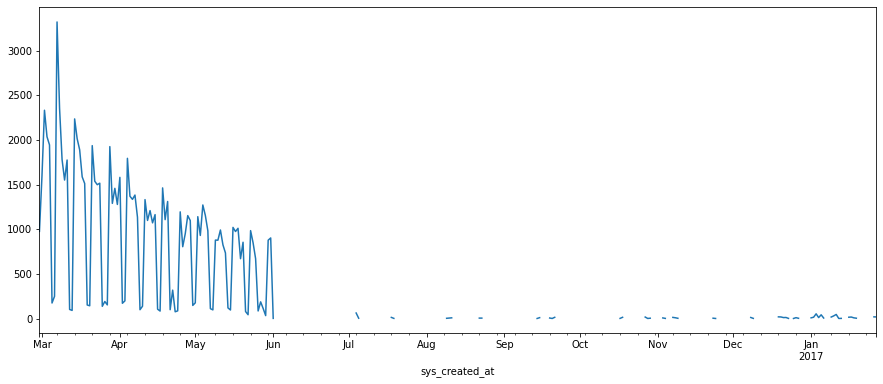

In [63]:
# Plotting number of tickets per day
data1.plot(figsize=(15,6))
plt.show()

In [64]:
# Since not many tickets after June 2016, we consider only the before values
inc_till_july = incfrq_filtered[incfrq_filtered.index < dt.datetime(2016,6,1)]

In [65]:
# new Series
data2 = inc_till_july['count_incidents']
data2 = data2.asfreq('D')
data2.index

DatetimeIndex(['2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03',
               '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11',
               '2016-03-12', '2016-03-13', '2016-03-14', '2016-03-15',
               '2016-03-16', '2016-03-17', '2016-03-18', '2016-03-19',
               '2016-03-20', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-25', '2016-03-26', '2016-03-27',
               '2016-03-28', '2016-03-29', '2016-03-30', '2016-03-31',
               '2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
      

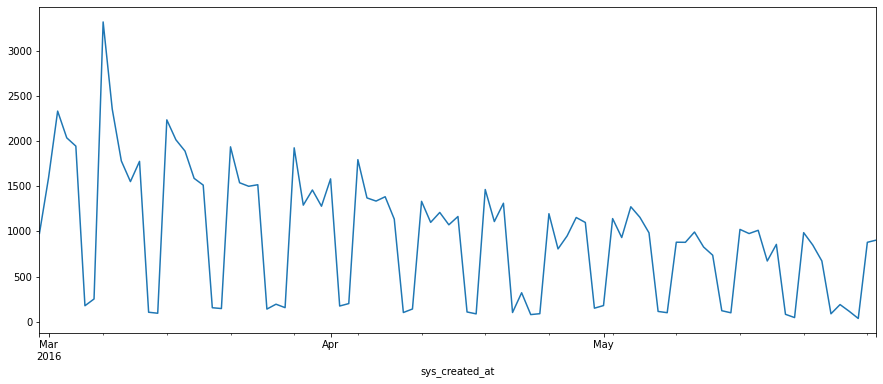

In [66]:
# Plotting number of tickets per day till June 2016
data2.plot(figsize=(15,6))
plt.show()

### Correlation Plotting

We plot the auto orrelation to identify the following terms of ARIMA - 

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

1. p: The number of lag observations included in the model, also called the lag order.
2. d: The number of times that the raw observations are differenced, also called the degree of differencing.
3. q: The size of the moving average window, also called the order of moving average.

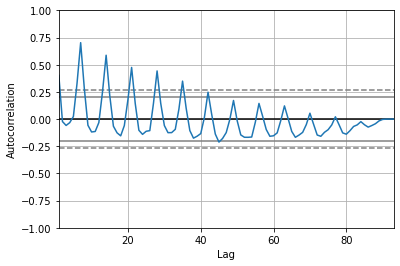

In [67]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(data2)
pyplot.show()

### Determining p,d,q - 

Based on the current understanding of correlation, we set p=5, d=1 and q=0

1. We forecast analysis for - 31/05/2016 to 1006/2016
2. We take a subset of original data - 20/05/2016 to 3105/016 (To maintain balance in plot)
3. We plot the time-series

In [68]:
# Choosing the model with minimum AIC and the ARIMA Model for Time Series Forecasting
mod = sm.tsa.statespace.SARIMAX(data2,order=(5,1,0))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4440      0.081     -5.491      0.000      -0.602      -0.285
ar.L2         -0.6338      0.079     -8.042      0.000      -0.788      -0.479
ar.L3         -0.5301      0.097     -5.462      0.000      -0.720      -0.340
ar.L4         -0.4123      0.087     -4.715      0.000      -0.584      -0.241
ar.L5         -0.4968      0.077     -6.468      0.000      -0.647      -0.346
sigma2      3.307e+05   5.18e+04      6.385      0.000    2.29e+05    4.32e+05


In [69]:
# Predicting the future values and the confidence interval
pred = results.get_prediction(start=pd.to_datetime('2016-5-31'),end=pd.to_datetime('2016-6-10'),dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.round()

2016-05-31    843.0
2016-06-01    380.0
2016-06-02    219.0
2016-06-03    301.0
2016-06-04    215.0
2016-06-05    490.0
2016-06-06    706.0
2016-06-07    528.0
2016-06-08    319.0
2016-06-09    340.0
2016-06-10    331.0
Freq: D, Name: predicted_mean, dtype: float64

### Visualization

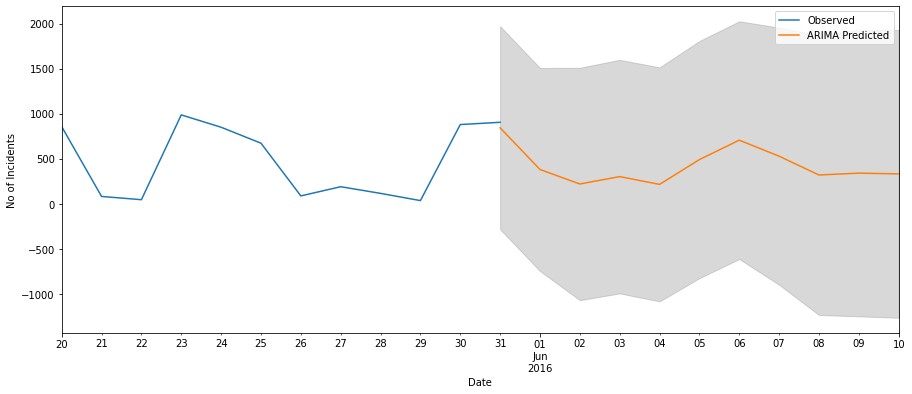

In [70]:
ax = data2['2016-5-20':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax,label='ARIMA Predicted',figsize=(15, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='grey',alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('No of Incidents')
plt.legend()
plt.show()